In [43]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from mapie.quantile_regression import MapieQuantileRegressor

import matplotlib.pyplot as plt

# Cargar datos y entrenar modelo

In [44]:
data = fetch_california_housing()
X, y = data.data, data.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

gb = GradientBoostingRegressor(n_estimators=100, loss="quantile", random_state=42)
gb.fit(X_train, y_train)

mapie_cqr = MapieQuantileRegressor(estimator=gb, alpha=0.1, method="quantile")
mapie_cqr.fit(X_cal, y_cal)

/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:66: FutureWarning: Class MapieQuantileRegressor is deprecated; WARNING: Deprecated path to import MapieQuantileRegressor. Please prefer the new path: [from mapie.regression import MapieQuantileRegressor].
  warnings.warn(msg, category=FutureWarning)


MapieQuantileRegressor(cv='split',
                       estimator=GradientBoostingRegressor(loss='quantile',
                                                           random_state=42))

# Obtener predicciones e intervalos

In [45]:
y_pred, y_pis = mapie_cqr.predict(X_test)

n_samples = 100
indices = np.random.choice(range(X_test.shape[0]), n_samples, replace=False)

y_test_subset = y_test[indices]
y_pred_subset = y_pred[indices]
lower_bound = y_pis[indices, 0].ravel()
upper_bound = y_pis[indices, 1].ravel()

interval_amplitude = upper_bound - lower_bound

results_df = pd.DataFrame({
    "True Values": y_test_subset,
    "Predictions": y_pred_subset,
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound,
    "Amplitude": interval_amplitude
})

/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


   True Values  Predictions  Lower Bound  Upper Bound  Amplitude
0        0.973     0.955093     0.717592     1.900891   1.183299
1        0.875     1.035769     0.676104     1.899752   1.223647
2        2.267     1.696739     0.794012     3.055478   2.261466
3        1.161     1.504481     1.170660     2.338823   1.168162
4        1.705     1.705652     1.296784     3.125571   1.828787
5        4.383     2.434081     1.110236     4.031114   2.920878
6        0.300     0.935618     0.568787     2.473784   1.904997
7        1.163     0.830075     0.377088     2.187923   1.810836
8        1.898     2.858220     1.403932     4.404503   3.000570
9        2.323     2.013103     1.558639     3.090132   1.531494


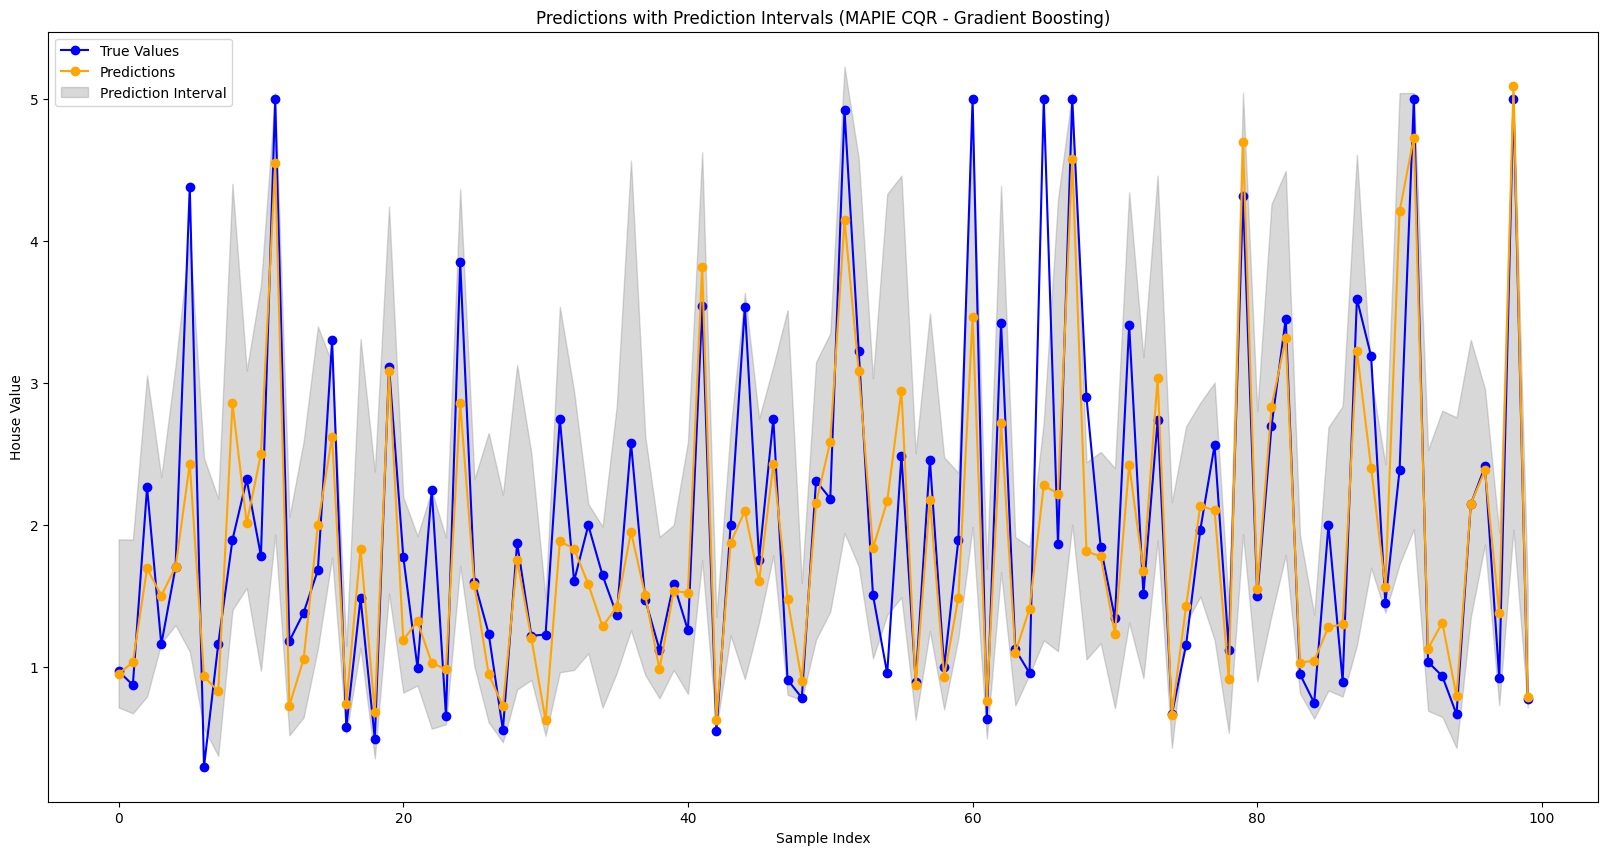

In [46]:
print(results_df.head(10))

plt.figure(figsize=(20, 10))
plt.plot(range(n_samples), results_df["True Values"], label="True Values", color="blue", marker="o")
plt.plot(range(n_samples), results_df["Predictions"], label="Predictions", color="orange", marker="o")
plt.fill_between(
    range(n_samples),
    results_df["Lower Bound"],
    results_df["Upper Bound"],
    color="gray",
    alpha=0.3,
    label="Prediction Interval"
)
plt.xlabel("Sample Index")
plt.ylabel("House Value")
plt.title("Predictions with Prediction Intervals (MAPIE CQR - Gradient Boosting)")
plt.legend()
plt.show()